In [1]:
%reload_ext autoreload
%autoreload 2

In [21]:
import os
import json
import shutil
from PIL import Image
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_dataset import k12ai_compute_mean_std 
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

## 裁剪

In [18]:
dataset = 'rcifar10'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
train_val_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'cifar10', 'train_val.json')
items = []
with open(train_val_json, 'r') as f:
    items = json.load(f)
len(items)

50000

In [4]:
train_val_df = pd.read_json(train_val_json, encoding="utf-8", orient='records')
train_val_df[:5]

,image_path,label
0,imgs/train/00000.jpg,6
1,imgs/train/00001.jpg,9
2,imgs/train/00002.jpg,9
3,imgs/train/00003.jpg,4
4,imgs/train/00004.jpg,1


In [5]:
grouped_by_label = train_val_df.groupby('label')
grouped_by_label.count()

,image_path
label,
0,5000
1,5000
2,5000
3,5000
4,5000
5,5000
6,5000
7,5000
8,5000


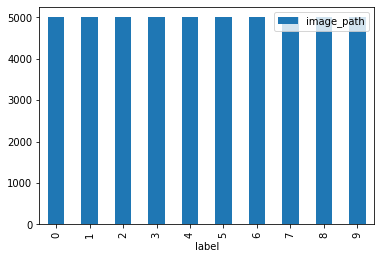

In [6]:
grouped_by_label.count().plot(kind='bar');

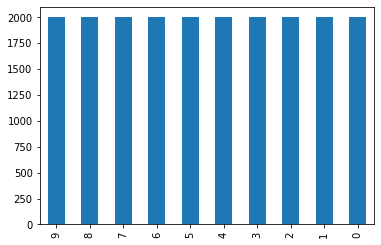

In [7]:
# 合理: 先分组, 然后组中随机样本
reduced_df = train_val_df.groupby('label').apply(pd.DataFrame.sample, n=2000, random_state=20, replace=False)
reduced_df['label'].value_counts().plot(kind='bar');

In [8]:
reduced_shuffle_df = reduced_df.sample(frac=1)
reduced_shuffle_df[15:25]

,,image_path,label
label,,,
3,4083,imgs/train/04083.jpg,3
1,20811,imgs/train/20811.jpg,1
7,48204,imgs/train/48204.jpg,7
1,2280,imgs/train/02280.jpg,1
4,2999,imgs/train/02999.jpg,4
8,10336,imgs/train/10336.jpg,8
7,5774,imgs/train/05774.jpg,7
9,16001,imgs/train/16001.jpg,9
7,48548,imgs/train/48548.jpg,7


In [9]:
train_valid_df, test_df = train_test_split(reduced_shuffle_df, test_size=0.2)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2)
len(train_df), len(valid_df), len(test_df), len(reduced_shuffle_df)

(12800, 3200, 4000, 20000)

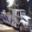

In [10]:
image_path = test_df[0:10]['image_path'].tolist()[0]
image_path = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'cifar10', image_path)
Image.open(image_path)

## 生成train.json/val.json/test.json

In [11]:
def generate_json_file(df, phase):
    src_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'cifar10')
    dst_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rcifar10')
    
    img_path = os.path.join(dst_root, 'imgs', phase)
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(img_path)
    
    results = []
    items = df.to_dict(orient='records')
    print(f'{phase} count: {len(items)}')
    for item in items:
        filename = os.path.basename(item['image_path'])
        src_path = os.path.join(src_root, item['image_path'])
        dst_path = os.path.join(img_path, filename)
        if not os.path.exists(src_path):
            print('not found:', src_path)
        if os.path.exists(dst_path):
            print('replce found:', dst_path)
        results.append({
            'image_path': f'imgs/{phase}/{filename}',
            'label': item['label']
        })
        # Image.open(src_path).resize((256, 256)).crop((16, 16, 240, 240)).save(dst_path)
        shutil.copy2(src_path, dst_path)
        
    with open(os.path.join(dst_root, f'{phase}.json'), 'w') as f:
        json.dump(results, f)
    return len(results)
        
test_count = generate_json_file(test_df, 'test')
train_count = generate_json_file(train_df, 'train')
val_count = generate_json_file(valid_df, 'val')

test count: 4000
train count: 12800
val count: 3200


## 生成info.json

In [13]:
datadir = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rcifar10')
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=datadir, jfiles=jfiles)

In [23]:
label_names = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

info = {
    'num_records': test_count+val_count+train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, indent=4)
    
info

{'num_records': 20000,
 'num_classes': 10,
 'label_names': ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'mean': [0.4915, 0.4824, 0.4468],
 'std': [0.1991, 0.1969, 0.1994]}

## 数据平衡分析

<Figure size 432x288 with 0 Axes>

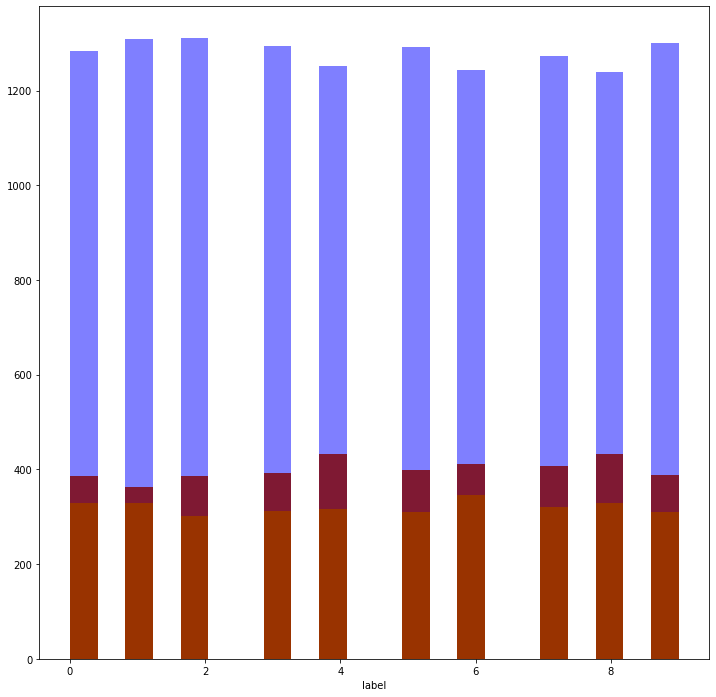

In [22]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'maroon', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()